# Observational Data Transport Mean Profile
*Akira Di Sandro, 7/16/20*
<br> In this notebook, I will be making a mean profile of transport for the observational data.

## 1. Import Packages as usual

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr
xr.set_options(display_style='html')
import intake
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

## 2. Open Observational Data

In [3]:
from scipy.io import loadmat
obs_data = loadmat('../Data/SolomonStrait_westernXsection_linear2bot_sat4surf.mat')

In [4]:
#along strait velocity saved in 255x99x590 matrix (depth x points along cross section x timestamps)
asv = obs_data['ASV']  #asv is in m/s

#lon: lon points along cross section, lat (same as lon), xdist: distance from start of cross section
lon = obs_data['bathy'][0][0][2][0]
lat = obs_data['bathy'][0][0][3][0]
xdist = obs_data['bathy'][0][0][4][0] #xdist is in km

#raw_time: datenums associated to each day mooring data was taken
raw_time = obs_data['time'][0]

#depth: array of all the depths possible
depth = obs_data['z'][:,0]  # depth is in m

## 3. Open Cluster 

In [30]:
from dask.distributed import Client
from dask_gateway import Gateway


gateway = Gateway()  # connect to Gateway

cluster = gateway.new_cluster()  # create cluster
cluster.scale(10)  # scale cluster

client = Client(cluster)  # connect Client to Cluster

In [31]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.3bd05a37b19b415a983a4d077c6f8a24 Dashboard: https://us-central1-b.gcp.pangeo.io/services/dask-gateway/clusters/prod.3bd05a37b19b415a983a4d077c6f8a24/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## 4. Calculating Transport Mean Profile Along Depth for One Time Stamp

In [5]:
asv.shape

(225, 99, 590)

I want to average the values of velocities across all time values stored in 'asv'. This 2d matrix, 'asv_avgtime' indexed by depth points (225 total) and points along cross-section will be in units of m/s still because it is just veolcity values.

In [6]:
asv_avgtime = np.mean(asv, axis=2)
asv_avgtime[np.isnan(asv_avgtime)]=0
asv_avgtime.shape

(225, 99)

To get the values of transport per unit depth for the observational data, I will have to use trapz to integrate along the cross section using xdist and the 99 values of velocity across all 225 depth levels. This will be stored in a 1d array of 225 values where each value is indexed by the depth level and will store the value of transport per unit depth (Sv/km). This is because 'xdist' is already in km.

In [7]:
obs_tpd = []
for i in range(asv_avgtime.shape[0]):
        vels_depth = asv_avgtime[i]          #vels_depth stores the i^th row of asv_avgtime (so the velocity values of that depth value)
        row_int = np.trapz(vels_depth, xdist)
        obs_tpd = np.append(obs_tpd, [row_int])

In [8]:
obs_tpd.shape

(225,)

In [9]:
depth

array([  10,   30,   50,   70,   90,  110,  130,  150,  170,  190,  210,
        230,  250,  270,  290,  310,  330,  350,  370,  390,  410,  430,
        450,  470,  490,  510,  530,  550,  570,  590,  610,  630,  650,
        670,  690,  710,  730,  750,  770,  790,  810,  830,  850,  870,
        890,  910,  930,  950,  970,  990, 1010, 1030, 1050, 1070, 1090,
       1110, 1130, 1150, 1170, 1190, 1210, 1230, 1250, 1270, 1290, 1310,
       1330, 1350, 1370, 1390, 1410, 1430, 1450, 1470, 1490, 1510, 1530,
       1550, 1570, 1590, 1610, 1630, 1650, 1670, 1690, 1710, 1730, 1750,
       1770, 1790, 1810, 1830, 1850, 1870, 1890, 1910, 1930, 1950, 1970,
       1990, 2010, 2030, 2050, 2070, 2090, 2110, 2130, 2150, 2170, 2190,
       2210, 2230, 2250, 2270, 2290, 2310, 2330, 2350, 2370, 2390, 2410,
       2430, 2450, 2470, 2490, 2510, 2530, 2550, 2570, 2590, 2610, 2630,
       2650, 2670, 2690, 2710, 2730, 2750, 2770, 2790, 2810, 2830, 2850,
       2870, 2890, 2910, 2930, 2950, 2970, 2990, 30

## 5. Plotting Observational Transport Mean Profile

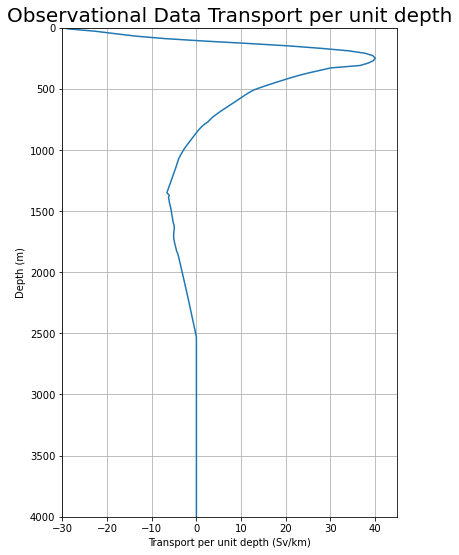

In [14]:
fig, ax = plt.subplots(figsize=(6,9))
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Transport per unit depth (Sv/km)')
ax.plot(obs_tpd, depth)           # this line will have transport vs depth
ax.grid(True)
ax.set_ylim(4000, 0)
ax.set_xlim(-30, 45)
plt.title('Observational Data Transport per unit depth', fontsize=20)
model_mp = plt.show()

## Closing Clusters after use

In [16]:
client.close()
cluster.close()

NameError: name 'client' is not defined